In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
import io
import seaborn as sns
import os
from os import listdir
from os.path import isfile, join
import colorcet as cc
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

In [2]:
def read_query_Files(path, join="median", max_rep=3, removeRandom=True):
    subfoldersIndex = [f.path for f in os.scandir(path) if f.is_dir() and ("vp_old" not in f.path)]
    pivos = ["BPP", "CONVEX", "GNAT", "SSS", "MAXSEPARATED", "MAXVARIANCE", "PCA", "IS", "HFI", "WDR", "SELECTION", "KMEDOIDS", "RANDOM"]
    repList = list(range(max_rep))
    df = pd.DataFrame(columns=["Índice", "Pivô", "K", "Tempo", "Cálculos_de_distância", "Acessos_ao_disco"])
    for indexPath in subfoldersIndex:
        files = [f for f in os.scandir(indexPath) if (f.is_file()) and ("stats" not in f.path) and (any([str(rep) in f.path for rep in repList]))]
        for pvt in pivos:
            pivo_files = [f for f in files if pvt in f.path]
            pvtDF = pd.DataFrame()
            index = str()
            pivot = str()
            for f in pivo_files:
                file = open(f)
                line = file.readline().rstrip().split(",")
                index = line[0]
                pivot = line[2]
                dfAux = pd.read_csv(f, sep=',', skiprows=1, header=0)
                pvtDF = pd.concat([pvtDF, dfAux])
            
            if len(pvtDF) != 0:
                pvtDF["index"] = index
                pvtDF["pivot"] = pivot
                if join == "median":
                    pvtDF = pvtDF.groupby(["index", "pivot", "k"])[["time", "count", "disk"]].median().reset_index()
                else:
                    pvtDF = pvtDF.groupby(["index", "pivot", "k"])[["time", "count", "disk"]].mean().reset_index()
                pvtDF = pvtDF[["index", "pivot", "k", "time", "count", "disk"]]
                pvtDF.columns = ["Índice", "Pivô", "K", "Tempo", "Cálculos_de_distância", "Acessos_ao_disco"]
                df = pd.concat([df, pvtDF])

    if removeRandom:
        df = df[df["Pivô"] != "RANDOM"]
    
    indexOrder = ["VPTREE", "MVPTREE", "OMNIKDTREE", "PMTREE", "SPBTREE"]
    df2 = pd.DataFrame(columns=df.columns)
        
    for index in indexOrder:
        dfAux = df[df["Índice"] == index]
        df2 = pd.concat([df2, dfAux])

    df2["Tempo"] = df2["Tempo"]/1e9
        
    return df2

def plot_query_calc_dist(path, outputName, join="median", max_rep=3, removeRandom=True, outputPath="./"):
    palette = sns.color_palette(cc.glasbey, n_colors=12)
    df2 = read_query_Files(path, join, max_rep, removeRandom)
    
    g = sns.FacetGrid(df2, col="Índice", hue="Pivô", col_wrap=1, height=3.5, aspect=1.5, sharey=False, sharex=False, 
                      palette=palette, 
                      hue_kws=dict(marker=["o", "v", "^", "<", "s", "p", "P", "X", "d", "H", ">", "*"], 
                                   markeredgewidth=[0.2]*13))
    g.map(sns.lineplot, "K", "Cálculos_de_distância")
    xticksList = [5, 50, 100]
    g.set(xticks=xticksList)
    g.set_xticklabels(xticksList)
    g.set(xlabel='')
    g.set(xlim=(5,101))

    for ax, i in zip(g.axes.flatten(), range(5)):
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_title('', x=0, y=0)
        ax.set(ylabel='')
    
    g.tight_layout()
    
    if outputPath[-1] == '/':
        plt.savefig(outputPath + "query_calc_dist_" + outputName + ".svg", dpi = 300)
    else:
        plt.savefig(outputPath + "/" + "query_calc_dist_" + outputName + ".svg", dpi = 300)
    
def plot_query_time(path, outputName, join="median", max_rep=3, removeRandom=True, outputPath="./"):
    palette = sns.color_palette(cc.glasbey, n_colors=12)
    df2 = read_query_Files(path, join, max_rep, removeRandom)

    g = sns.FacetGrid(df2, col="Índice", hue="Pivô", col_wrap=1, height=3.5, aspect=1.5, sharey=False, sharex=False, 
                      palette=palette, 
                      hue_kws=dict(marker=["o", "v", "^", "<", "s", "p", "P", "X", "d", "H", ">", "*"], 
                                   markeredgewidth=[0.2]*13))
    g.map(sns.lineplot, "K", "Tempo")
    xticksList = [5, 50, 100]
    g.set(xticks=xticksList)
    g.set_xticklabels(xticksList)
    g.set(xlabel='')
    g.set(xlim=(5,101))

    for ax, i in zip(g.axes.flatten(), range(5)):
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_title('', x=0, y=0)
        ax.set(ylabel='')

    g.tight_layout()
    
    if outputPath[-1] == '/':
        plt.savefig(outputPath + "query_time_" + outputName + ".svg", dpi = 300)
    else:
        plt.savefig(outputPath + "/" + "query_time_" + outputName + ".svg", dpi = 300)
    
def plot_query_disk_access(path, outputName, join="median", max_rep=3, removeRandom=True, outputPath="./"):
    palette = sns.color_palette(cc.glasbey, n_colors=12)
    df2 = read_query_Files(path, join, max_rep, removeRandom)

    g = sns.FacetGrid(df2, col="Índice", hue="Pivô", col_wrap=1, height=3.5, aspect=1.5, sharey=False, sharex=False, 
                      palette=palette, 
                      hue_kws=dict(marker=["o", "v", "^", "<", "s", "p", "P", "X", "d", "H", ">", "*"], 
                                   markeredgewidth=[0.2]*13))
    g.map(sns.lineplot, "K", "Acessos_ao_disco")
    xticksList = [5, 50, 100]
    g.set(xticks=xticksList)
    g.set_xticklabels(xticksList)
    g.set(xlabel='')
    g.set(xlim=(5,101))

    for ax, i in zip(g.axes.flatten(), range(5)):
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_title('', x=0, y=0)
        ax.set(ylabel='')

    g.tight_layout()
    
    if outputPath[-1] == '/':
        plt.savefig(outputPath + "query_disk_access_" + outputName + ".svg", dpi = 300)
    else:
        plt.savefig(outputPath + "/" + "query_disk_access_" + outputName + ".svg", dpi = 300)

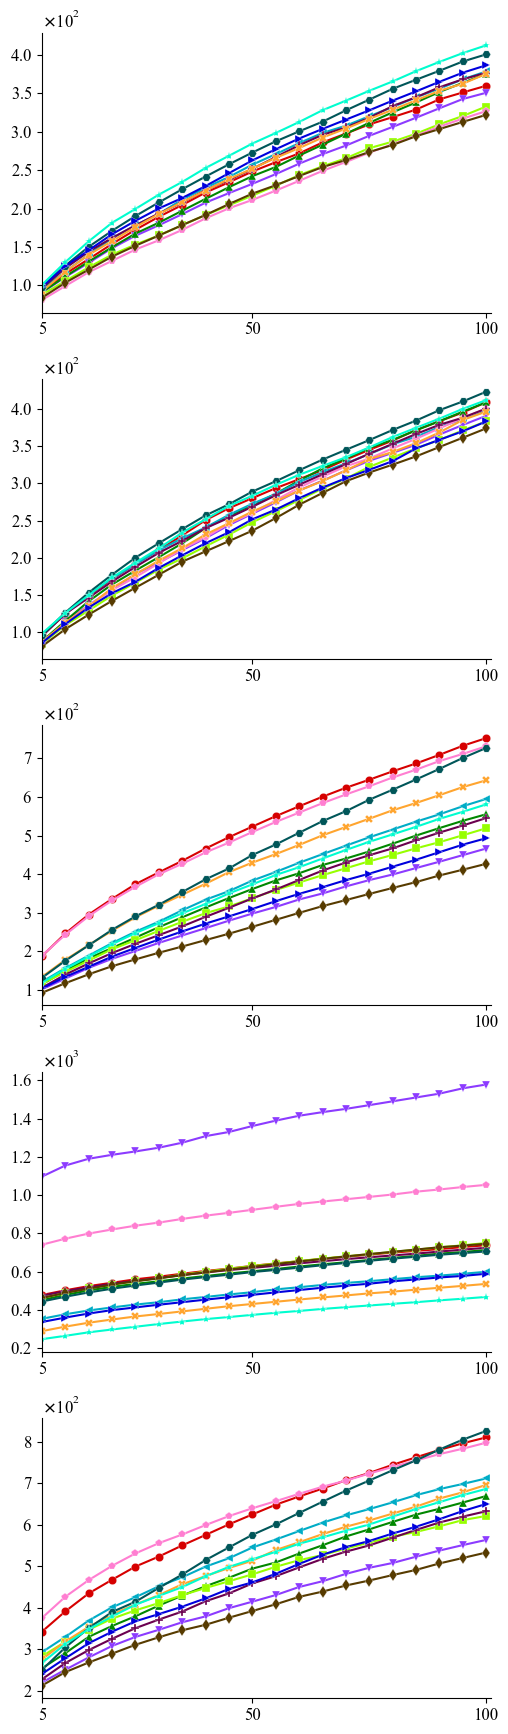

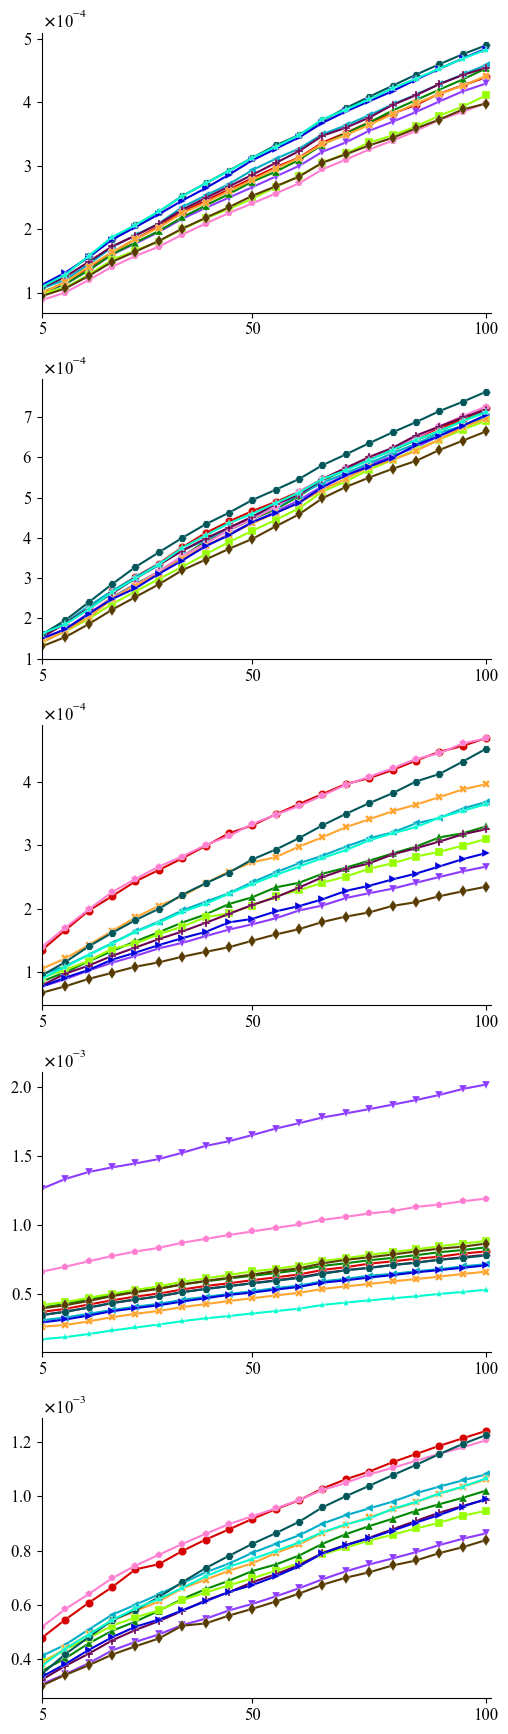

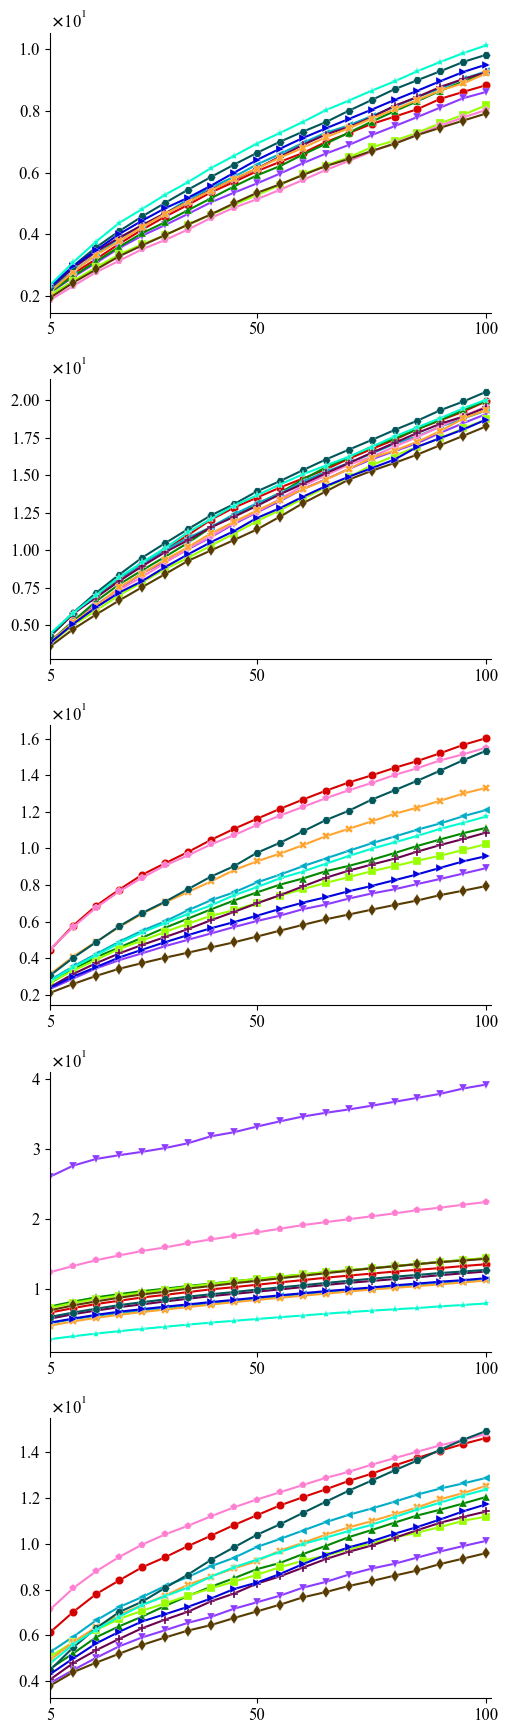

In [4]:
dataset = "cities"

plot_query_calc_dist("../../../../../tcc_expt/consultas/" + dataset, 
                     outputName=dataset, 
                     join = "mean", 
                     outputPath="/home/joaoleite/Documents/TCC/Figuras/Figs_expts", max_rep=1)

plot_query_time("../../../../../tcc_expt/consultas/" + dataset, 
                outputName=dataset,
                join = "mean",
                outputPath="/home/joaoleite/Documents/TCC/Figuras/Figs_expts", max_rep=1)

plot_query_disk_access("../../../../../tcc_expt/consultas/" + dataset, 
                       outputName=dataset,
                       join = "mean",
                       outputPath="/home/joaoleite/Documents/TCC/Figuras/Figs_expts", max_rep=1)

In [5]:
def read_stats_Files(path, join="median", removeRandom=True, max_rep = 3, time='s'):
    query_data = []
    subfoldersIndex = [f.path for f in os.scandir(path) if f.is_dir()]
    for directory in subfoldersIndex:
        onlyfiles = [f.path for f in os.scandir(directory) if ((f.is_file()) and ('stats' in f.path))]
        for filePath in onlyfiles:
            try:
                file = open(filePath)
                lines = file.readlines()
                data = [line.rstrip().split(",") for line in lines]
                index = data[0][0]
                pivot = data[0][2]
                data = data[2:2+max_rep]
                for i in range(0, len(data)):
                    data[i] = [index, pivot] + data[i]
                query_data.extend(data)
            finally:
                file.close()
    
    columns = ["Índice", "Pivô", "Tempo", "Cálculos_de_distância"]
    query_data.insert(0, columns)            
    data = [" ".join(line) for line in query_data]
    df = pd.read_csv(io.StringIO('\n'.join(data)), delim_whitespace=True)
    df = df[df["Pivô"] != "RANDOM"]
    if time == 's':
        df["Tempo"] = df["Tempo"]/1e9
    elif time == 'ms':
        df["Tempo"] = df["Tempo"]/1e6
    group_df = pd.DataFrame()

    if join == "mean":
        group_df = df.groupby(["Índice", "Pivô"])[["Tempo", "Cálculos_de_distância"]].mean().reset_index()
    else:
        group_df = df.groupby(["Índice", "Pivô"])[["Tempo", "Cálculos_de_distância"]].median().reset_index()

    df2 = pd.DataFrame(columns=group_df.columns)
    indexOrder = ["VPTREE", "MVPTREE", "OMNIKDTREE", "PMTREE", "SPBTREE"]
    pivos = ["BPP", "CONVEX", "GNAT", "SSS", "MAXSEPARATED", "MAXVARIANCE", "PCA", "IS", "HFI", "WDR", "SELECTION", "KMEDOIDS", "RANDOM"]
    
    for i, index in enumerate(indexOrder):
        for pvt in pivos:
            dfAux = group_df[(group_df["Índice"] == index) & (group_df["Pivô"] == pvt)]
            if dfAux.size != 0:
                df2 = pd.concat([df2, dfAux])
    
    return df2

def annotate_bars(data, data2, **kwargs):
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'top', rotation = 90)

def plot_build(path, outputName, join="median", removeRandom=True, outputPath="./", max_rep = 3, time = 's'):
    palette = sns.color_palette(cc.glasbey, n_colors=12)
    df = read_stats_Files(path, join, removeRandom, max_rep=max_rep, time=time)
    
    g = sns.catplot(data=df, x="Pivô", y="Tempo", hue="Pivô", col="Índice", kind="bar", dodge=False, 
                    palette=palette, sharey=False, col_wrap=1, height=3.5, aspect=1.5)
    g.set_xticklabels(rotation=45, ha='right')
    g.set(yscale='log')
    g.map(annotate_bars, "Pivô", "Tempo")
    g.set_titles("")
    g.set(ylabel='')
    g.set(xlabel='')

    g.tight_layout()
    
    if outputPath[-1] == '/':
        plt.savefig(outputPath + "build_" + outputName + ".svg", dpi = 300)
    else:
        plt.savefig(outputPath + "/" + "build_" + outputName + ".svg", dpi = 300)

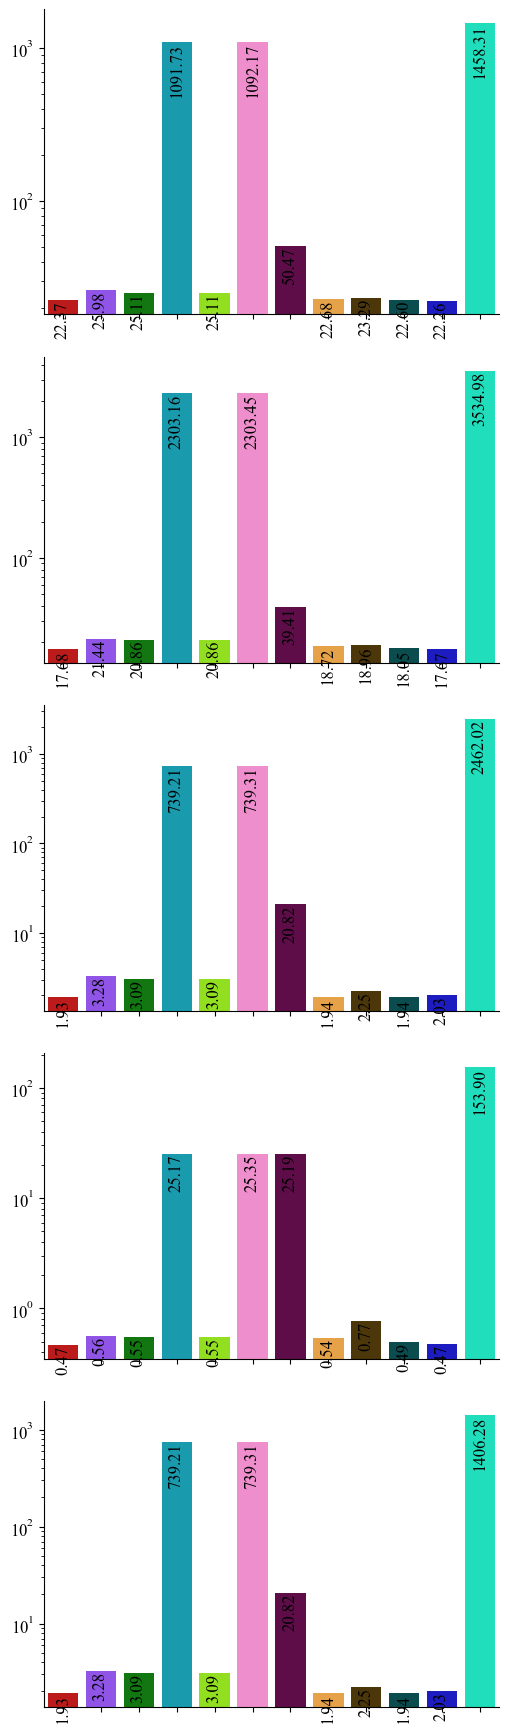

In [6]:
dataset = "la"

plot_build("../../../../../tcc_expt/consultas/" + dataset, 
           outputName=dataset, 
           join = "mean",
           outputPath="/home/joaoleite/Documents/TCC/Figuras/Figs_expts", max_rep=1, time='ms')

In [3]:
def annotate_bars2(data, data2, **kwargs):
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.0f'), (p.get_width()/1000, p.get_y() + p.get_height() / 2),
                    ha='center', va='center', xytext=(5, 0), textcoords='offset points')

# def custom_plot(data, sort_column, **kwargs):
#     data2 = data.sort_values(by=sort_column, ascending=False)
    
#     #ax = sns.barplot(data=data2, order=data2['level_1'], orient='horizontal', **kwargs)
#     ax = sns.barplot(data=data2, orient='h', order=data2['level_1'], **kwargs)
#     plt.gca().set_xticklabels(data2['level_1'])
#     return ax


def ranking_by_index(path, rankBy = 'Cálculos_de_distância', 
            listIndex = ['VPTREE', 'MVPTREE', 'OMNIKDTREE', 'PMTREE', 'SPBTREE'], join = "median", asc = True, 
            max_rep = 3, removeRandom = True, listDatasets = ['cities', 'card', 'avila'], outputPath="./", 
            outputName = 'rank', top='top_1'):
    
    df_rank = pd.DataFrame()
    for index in listDatasets:
        folderName = os.path.basename(index) 
        df = read_query_Files(os.path.join(path, folderName), join=join, max_rep=max_rep, removeRandom=removeRandom)
        df.set_index(['Índice', 'Pivô', 'K'], inplace=True)
        df_rank = pd.concat([df_rank, df[rankBy]], axis='columns')
    df_rank.columns = map(lambda x: x[0] + '_' + x[1], zip(df_rank.columns, listDatasets))
    
    df_rank_sum = pd.DataFrame(index=df_rank.index, 
                               columns=['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0'],
                               dtype=float).droplevel(-1).fillna(0.0)
    df_rank_sum = df_rank_sum[~df_rank_sum.index.duplicated(keep='first')]

    
    pivots = ["BPP", "CONVEX", "GNAT", "SSS", "MAXSEPARATED", "MAXVARIANCE", "PCA", "IS", "HFI", "WDR", "SELECTION", "KMEDOIDS"] 
    for idx in listIndex:
        for k in range(5, 101, 5):
            df = df_rank.loc[(idx, slice(None), k), :]
            rank = df.rank(axis=0, method='dense', ascending=asc).droplevel([0,2]).astype(str)
            for pvt in pivots:
                aux = rank.loc[pvt, :]
                for pos in aux:
                    df_rank_sum.loc[(idx, pvt), pos] += 1.0
    
    
    df_rank_sum['top_1'] = df_rank_sum['1.0']
    df_rank_sum['top_2'] = df_rank_sum['1.0'] + df_rank_sum['2.0']
    df_rank_sum['top_3'] = df_rank_sum['1.0'] + df_rank_sum['2.0'] + + df_rank_sum['3.0']
    df_rank_sum['top_1'] = df_rank_sum['top_1'].astype('int')
    df_rank_sum['top_2'] = df_rank_sum['top_2'].astype('int')
    df_rank_sum['top_3'] = df_rank_sum['top_3'].astype('int')
    df_rank_sum = df_rank_sum[['top_1', 'top_2', 'top_3', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0']]
        
    df = df_rank_sum.reset_index()
    
#     g = sns.FacetGrid(df, col='level_0', col_wrap=1, height=3, aspect=1.8, sharex=False)
#     #g.map_dataframe(custom_plot, y='level_1', x=top, sort_column=top)
#     g.map_dataframe(custom_plot, y='level_1', x=top, sort_column=top)
#     g.set_titles(col_template='')
#     g.set(xscale='log')
#     g.map(annotate_bars2, top, "level_1")
#     g.set_titles('')
#     g.set(xlabel='')
#     g.set(ylabel='')

    df2 = pd.DataFrame()
    
    for idx in listIndex:
        aux = df[df['level_0'] == idx]
        aux = aux.sort_values(by=top, ascending=False)
        #sns.barplot(aux, x='level_1', y=top)
        df2 = pd.concat([df2, aux])
        
        
    df.to_csv("pla_top_3.csv", index=False, header=True)
#     aux = df[df['level_0'] == 'VPTREE']
#     aux = aux.sort_values(by=top, ascending=False)
    
#     p = sns.barplot(aux, x=top, y='level_1', orient="h")
#     p.set(xscale='log')
#     p.set(xlabel='')
#     p.set(ylabel='')

    g = sns.catplot(df2, x=top, y='level_1', col='level_0', kind='bar', orient='h', sharex=False, sharey=False, 
                    col_wrap=1, height=3.3, aspect=2.1, width=1.0, dodge=False, color='orange')
    #g.set(xscale='log')
    g.map(annotate_bars2, top, "level_1")
    #g.set_titles('')
    g.set(xlabel='')
    g.set(ylabel='')
    
#     palette = sns.color_palette(cc.glasbey, n_colors=12)
#     pald = zip(pivos, palette)
# #     g = sns.catplot(data=df2, x=top, y='level_1', hue='level_1', col="level_0", kind="bar", dodge=False, 
# #                     sharex=False, sharey=True, col_wrap=1, height=3.5, aspect=1.5)

#     g = sns.FacetGrid(df2, col='level_0', sharex=False, sharey=True, col_wrap=1, height=3.5, aspect=1.5)
#     g.map_dataframe(sns.barplot, x=top, y='level_1')
#     g.map(annotate_bars2, top, "level_1")
    

    #Arrumar o palette para descomentar isso
#     for ax in g.axes.flat:
#         ax.set_yticklabels([])
    
    g.tight_layout()
        
    if outputPath == None:
        return df2
    elif outputPath[-1] == '/':
        plt.savefig(outputPath + "ranking_" + outputName + "_" + top + "_" + ".svg", dpi = 300)
    else:
        plt.savefig(outputPath + "/" + "ranking_" + outputName + "_" + top + "_" + ".svg", dpi = 300)


,level_0,level_1,top_1,top_2,top_3,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
5,VPTREE,MAXVARIANCE,118,154,206,118.0,36.0,52.0,14.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,VPTREE,KMEDOIDS,72,120,120,72.0,48.0,0.0,3.0,29.0,27.0,21.0,0.0,20.0,4.0,10.0,6.0
10,VPTREE,SELECTION,0,32,95,0.0,32.0,63.0,23.0,22.0,6.0,15.0,22.0,9.0,33.0,12.0,3.0
7,VPTREE,IS,0,19,80,0.0,19.0,61.0,20.0,26.0,52.0,24.0,9.0,26.0,3.0,0.0,0.0
8,VPTREE,HFI,21,50,64,21.0,29.0,14.0,16.0,0.0,0.0,0.0,3.0,149.0,8.0,0.0,0.0
2,VPTREE,GNAT,0,35,44,0.0,35.0,9.0,33.0,14.0,3.0,6.0,0.0,0.0,20.0,69.0,51.0
6,VPTREE,PCA,21,41,41,21.0,20.0,0.0,19.0,89.0,50.0,0.0,16.0,4.0,1.0,20.0,0.0
3,VPTREE,SSS,0,2,20,0.0,2.0,18.0,4.0,16.0,18.0,61.0,79.0,22.0,0.0,0.0,20.0
4,VPTREE,MAXSEPARATED,0,7,20,0.0,7.0,13.0,2.0,18.0,0.0,14.0,0.0,3.0,5.0,107.0,71.0
9,VPTREE,WDR,8,20,20,8.0,12.0,0.0,76.0,4.0,19.0,38.0,7.0,3.0,48.0,13.0,12.0


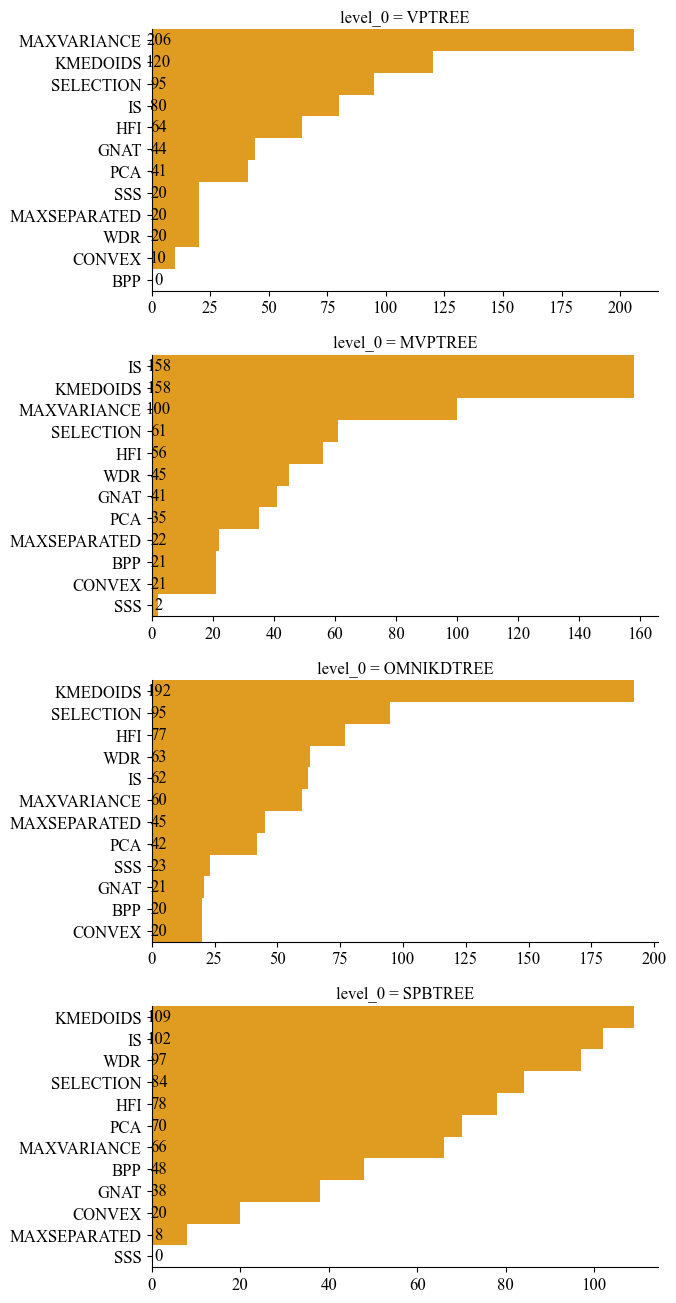

In [7]:
ranking_by_index(path='../../../../../tcc_expt/consultas/', rankBy='Tempo', join='mean', asc=True, 
        max_rep=1, removeRandom=True, listIndex=['VPTREE', 'MVPTREE', 'OMNIKDTREE', 'SPBTREE'],
        listDatasets=['cities', 'avila', 'internet', 'card', 'ulcer', 'nasa', 'aloi', 'sift', 'sift', 'mnist_s', 'cophir', 'la'], 
        outputPath=None, outputName='accum', top='top_3')

#"/home/joaoleite/Documents/TCC/Figuras/Figs_expts"


In [9]:
df = read_query_Files("../../../../../tcc_expt/consultas/la", join="mean", max_rep=1, removeRandom=True)
aux = df[df['Índice'] == 'VPTREE']
print(aux[aux['Pivô'] == 'KMEDOIS'])
#print(aux[aux['Índice'] == 'PMTREE'])

Empty DataFrame
Columns: [Índice, Pivô, K, Tempo, Cálculos_de_distância, Acessos_ao_disco]
Index: []


In [102]:
# df = read_stats_Files("../../../../../tcc_expt/consultas/internet", join="mean", removeRandom=True, max_rep = 1, time='ms')
# print(df)